# FESDModel - Model Evaluation

FESD - Fault estimation for skeleton detection - is a suite that aims at finding faults in joints of skeletons, which are detected by human pose estimatiors.

FESDData is the sister project to this notebook, which aims at recording depth and rgb data, as well as populating the data with human poses from variing human pose estimators.

Furthermore, FESTData augments all data based on joint confidence.

FFESDModel aims to develop and evaluate a model based on the faulty and augmented joint data as well as RGBD data.

## Libraries

We need a range of libraries which are imported here. We also define some constants.

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
from pathlib import Path
from time import time

from data import FESDDataset
from data import Frame, AugmentationParams
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
sns.set()

import cv2

from model import FESD, train, val, test
import copy

import scipy

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms

import datetime

from utils import AvgMeter, clip_gradient, get_scheduler
from utils.mode import Mode
from utils import err2gt, gt2err

from copy import deepcopy

from tqdm.notebook import tqdm

num_gpus = torch.cuda.device_count()
is_cuda = torch.cuda.is_available()
print(f"Num cuda GPUs: {num_gpus}")
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

Num cuda GPUs: 1


In [ ]:
RECORDING_DIR = Path('H:/Recordings/')
CHECKPOINT_DIR = Path('checkpoints')

## Metadata Loading

Firstly we need to import all the recordings into the notebook.


In [ ]:
with open(file="Exercises.json", mode='r') as file:
  exercises_json = json.load(file)['Exercises']

with open(file="JointErrors.json", mode='r') as file:
  joint_error_json = json.load(file)

with open(file="SkeletonErrors.json", mode='r') as file:
  skeleton_error_json = json.load(file)

len(exercises_json)

13

In [ ]:
batchsize = 10
im_size = 300

test_exercises = ['E-0.01', 'E-1.01', 'E-2.01', 'E-3.01']

dataset_train = FESDDataset(RECORDING_DIR, im_size, test_exercises, randomize_augmentation_params=True)
dataset_train.randomize_augmentation_params = True

dataset_test = FESDDataset(RECORDING_DIR, im_size, test_exercises, test=True)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batchsize)
test_loader = torch.utils.data.DataLoader(dataset_test)

Recordings Found: 17
Total Frames: 510
Recordings Found: 9
Total Frames: 270
51
270


In [ ]:
joint_names_all = ["-", "Head", "Neck", "Torso", "Waist", "Left collar", "Left shoulder", "Left elbow", "Left wrist", "Left hand", "-", "Right collar", "Right shoulder", "Right elbow", "Right wrist", "Right hand", "-", "Left hip", "Left knee", "Left ankle", "-", "Right hip", "Right knee", "Right ankle", "-"]
joint_names = [i for i in joint_names_all if i != '-']

body_halves = np.array(["Upper Half", "Lower Half"])
limbs = np.array(["Head", "Torso", "Left arm", "Right arm", "Left leg", "Right leg"])

upper_body_i = [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
lower_body_i = [3, 14, 15, 16, 17, 18, 19]

torso_i     = [2, 3, 4, 9]
head_i      = [0, 1]
left_arm_i  = [5, 6, 7, 8]
right_arm_i = [10, 11, 12, 13]
left_leg_i  = [14, 15, 16]
right_leg_i = [17, 18, 19]

joint_errors = []
for je in joint_error_json:
  joint_errors.append(je["Name"])

In [ ]:
i = 500
mode = Mode.FULL_BODY
dataset_train.mode = mode
rgb, depth, pose_2d, gt, session = dataset_train[i]
dataset_train.frame.show()

## Model Evaluation

Here we create all graphs and analysis for the training

In [ ]:
# Load the results of training and testing

df_model = pd.read_parquet('ModelAnalysis.parquet.gzip')
df_model["difficulty"] = df_model.apply(lambda x: int(x["exercise"][2]), axis=1)
df_model["mode"] = df_model["mode"].apply(lambda x: Mode.from_str(mode_str=x))
print(df_model.columns)

Index(['epoch', 'iteration', 'joint_id', 'gts', 'preds', 'confidences',
       'Avg loss', 'loss', 'accuracy', 'tp', 'tn', 'fp', 'fn', 'precision',
       'recall', 'f1', 'cohens_kappa', 'learning_rate', 'train_test',
       'exercise', 'simplified', 'mode', 'difficulty'],
      dtype='object')


In [ ]:
df_model["p"] = df_model["tp"] + df_model["fp"]
df_model["n"] = df_model["tn"] + df_model["fn"]
df_model["p/(p+n)"] = df_model["p"] / (df_model["n"] + df_model["p"])

In [ ]:
coi = ["difficulty", "p/(p+n)", "accuracy", "precision", "recall", "f1", "cohens_kappa"]
coi_tf_pn = ["tp", "tn", "fp", "fn", "p", "n"]

### Training Evaluation

In [ ]:
df_model_train = df_model[df_model["train_test"] == "train"]

#### Full Body Model

In [ ]:
df_model_train_fb = df_model_train[df_model_train["mode"] == Mode.FULL_BODY]

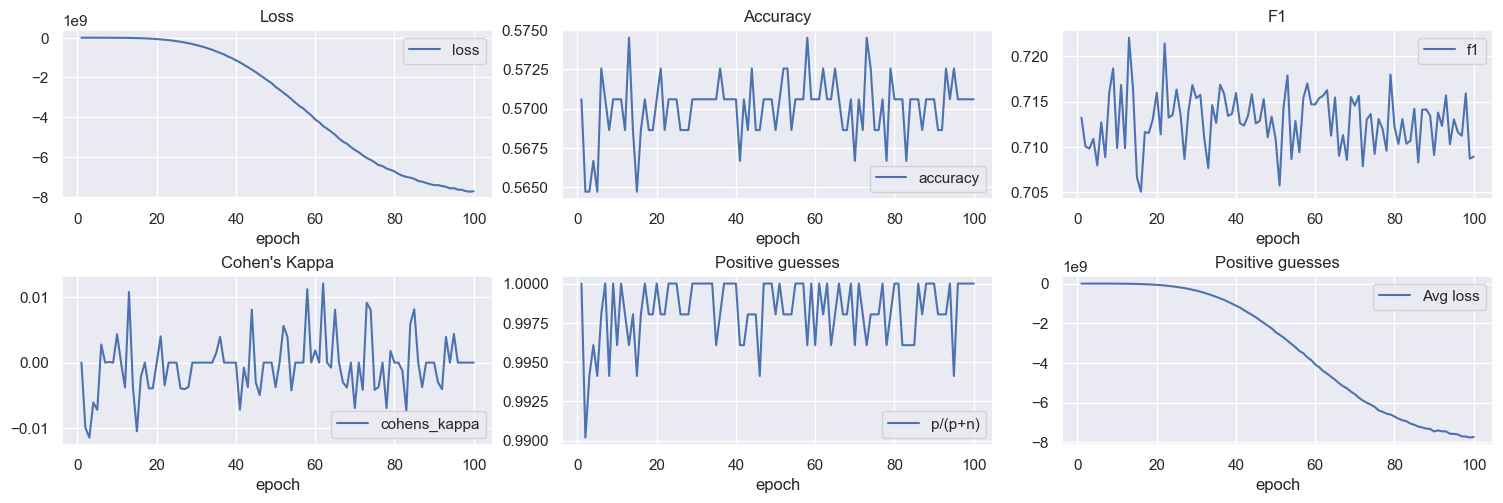

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=3)

df_model_train_fb[["epoch", "loss"]].groupby("epoch").mean().plot(y="loss", figsize=(15, 5), title="Loss", ax=axs[0][0])
df_model_train_fb[["epoch", "accuracy"]].groupby("epoch").mean().plot(y="accuracy" , figsize=(15, 5), title="Accuracy", ax=axs[0][1])
df_model_train_fb[["epoch", "f1"]].groupby("epoch").mean().plot(y="f1" , figsize=(15, 5), title="F1", ax=axs[0][2])
df_model_train_fb[["epoch", "cohens_kappa"]].groupby("epoch").mean().plot(y="cohens_kappa" , figsize=(15, 5), title="Cohen's Kappa", ax=axs[1][0])
df_model_train_fb[["epoch", "p/(p+n)"]].groupby("epoch").mean().plot(y="p/(p+n)" , figsize=(15, 5), title="Positive guesses", ax=axs[1][1])
df_model_train_fb[["epoch", "Avg loss"]].groupby("epoch").mean().plot(y="Avg loss" , figsize=(15, 5), title="Positive guesses", ax=axs[1][2])
fig.tight_layout(pad=.5)
plt.show()

#### Half Body

In [ ]:
df_model_train_hb = df_model_train[df_model_train["mode"] == Mode.HALF_BODY]
df_model_train_hb["joint"] = df_model_train_hb["joint_id"].apply(lambda x: body_halves[x])

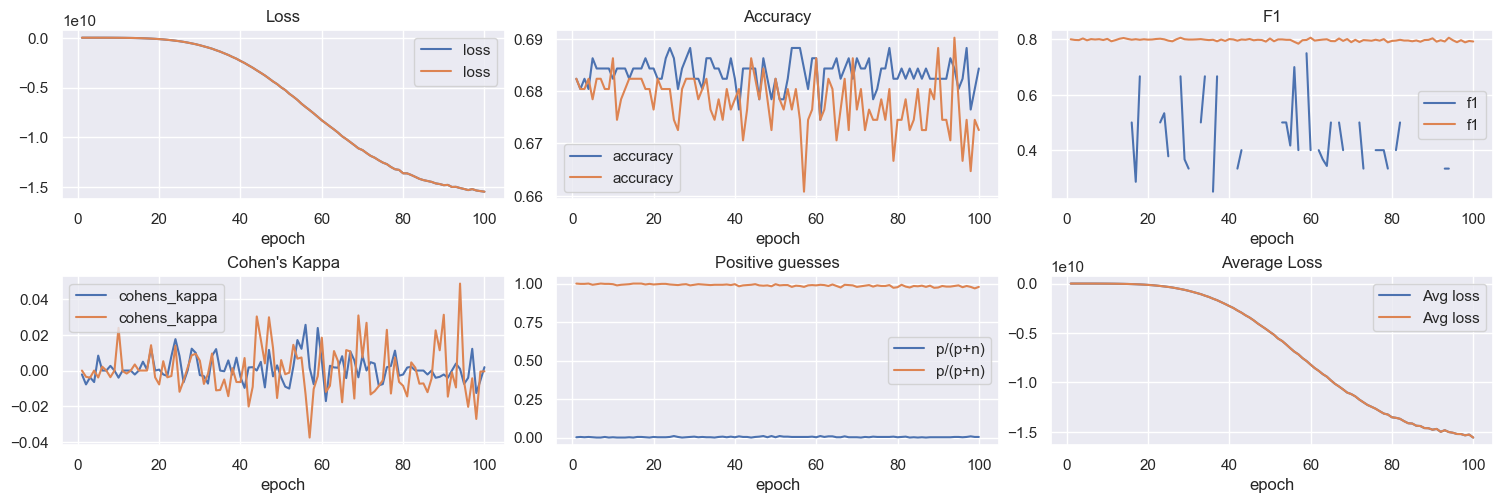

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=3)

vals_lh = df_model_train_hb[df_model_train_hb["joint"] == "Lower Half"]
vals_uh = df_model_train_hb[df_model_train_hb["joint"] == "Upper Half"]

def plot(df, axs):
  df = df[["epoch", "loss", "accuracy", "f1", "cohens_kappa", "p/(p+n)", "Avg loss"]].groupby(["epoch"]).mean()
  
  df.plot(y="loss", figsize=(15, 5), title="Loss", ax=axs[0][0])
  df.plot(y="accuracy" , figsize=(15, 5), title="Accuracy", ax=axs[0][1])
  df.plot(y="f1" , figsize=(15, 5), title="F1", ax=axs[0][2])
  df.plot(y="cohens_kappa" , figsize=(15, 5), title="Cohen's Kappa", ax=axs[1][0])
  df.plot(y="p/(p+n)" , figsize=(15, 5), title="Positive guesses", ax=axs[1][1])
  df.plot(y="Avg loss" , figsize=(15, 5), title="Average Loss", ax=axs[1][2])

plot(vals_lh, axs)
plot(vals_uh, axs)

fig.tight_layout(pad=.5)
plt.show()

#### Limbs

How to improve models
- implement balanced batching
- better cost/loss function
2. use single error
1. use inception network for RGB and depth
- Confusion matrix

R: RGB -> Grey
G: Depth
B: Black and white joints
Make 4 pictures of one example

In [ ]:
df_model_train_hb = df_model_train[df_model_train["mode"] == Mode.LIMBS]
df_model_train_hb["joint"] = df_model_train_hb["joint_id"].apply(lambda x: limbs[x])

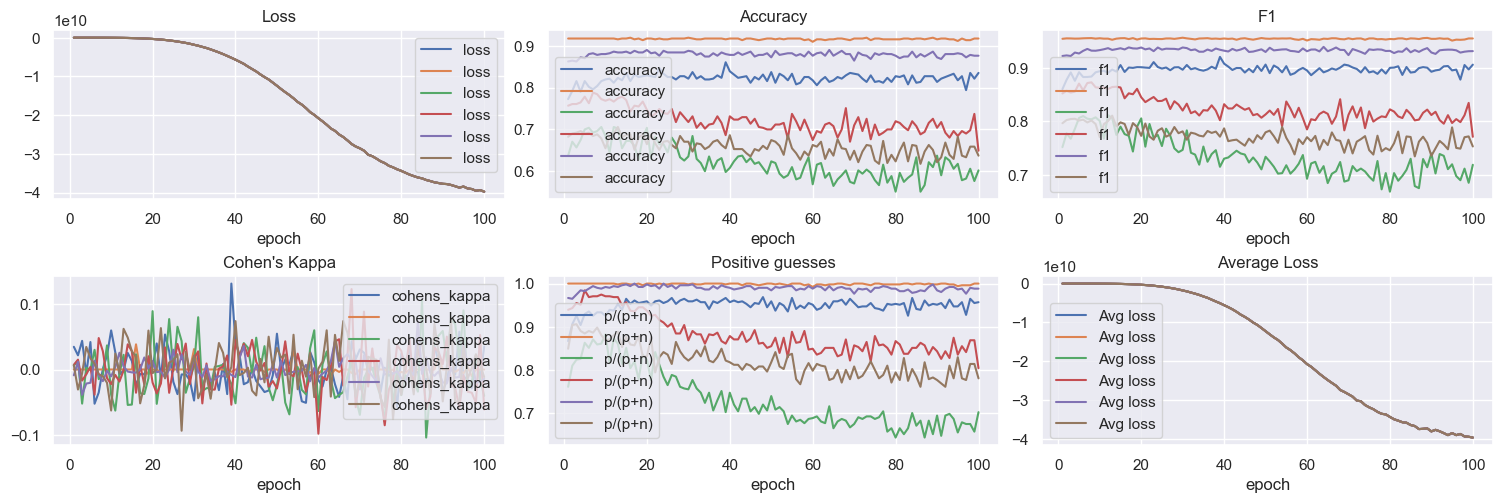

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=3)

vals_uh = df_model_train_hb[df_model_train_hb["joint"] == "Upper Half"]

def plot(df, axs):
  df = df[["epoch", "loss", "accuracy", "f1", "cohens_kappa", "p/(p+n)", "Avg loss"]].groupby(["epoch"]).mean()
  
  df.plot(y="loss", figsize=(15, 5), title="Loss", ax=axs[0][0])
  df.plot(y="accuracy" , figsize=(15, 5), title="Accuracy", ax=axs[0][1])
  df.plot(y="f1" , figsize=(15, 5), title="F1", ax=axs[0][2])
  df.plot(y="cohens_kappa" , figsize=(15, 5), title="Cohen's Kappa", ax=axs[1][0])
  df.plot(y="p/(p+n)" , figsize=(15, 5), title="Positive guesses", ax=axs[1][1])
  df.plot(y="Avg loss" , figsize=(15, 5), title="Average Loss", ax=axs[1][2])

for limb in limbs:
  df = df_model_train_hb[df_model_train_hb["joint"] == limb]
  plot(df, axs)

fig.tight_layout(pad=.5)
plt.show()

#### Joints

In [ ]:
df_model_train_jt = df_model_train[df_model_train["mode"] == Mode.JOINTS]
df_model_train_jt["joint"] = df_model_train_jt["joint_id"].apply(lambda x: joint_names[x])

C:\Users\leona\AppData\Local\Temp\ipykernel_24504\1644226166.py:17: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout(pad=.5)


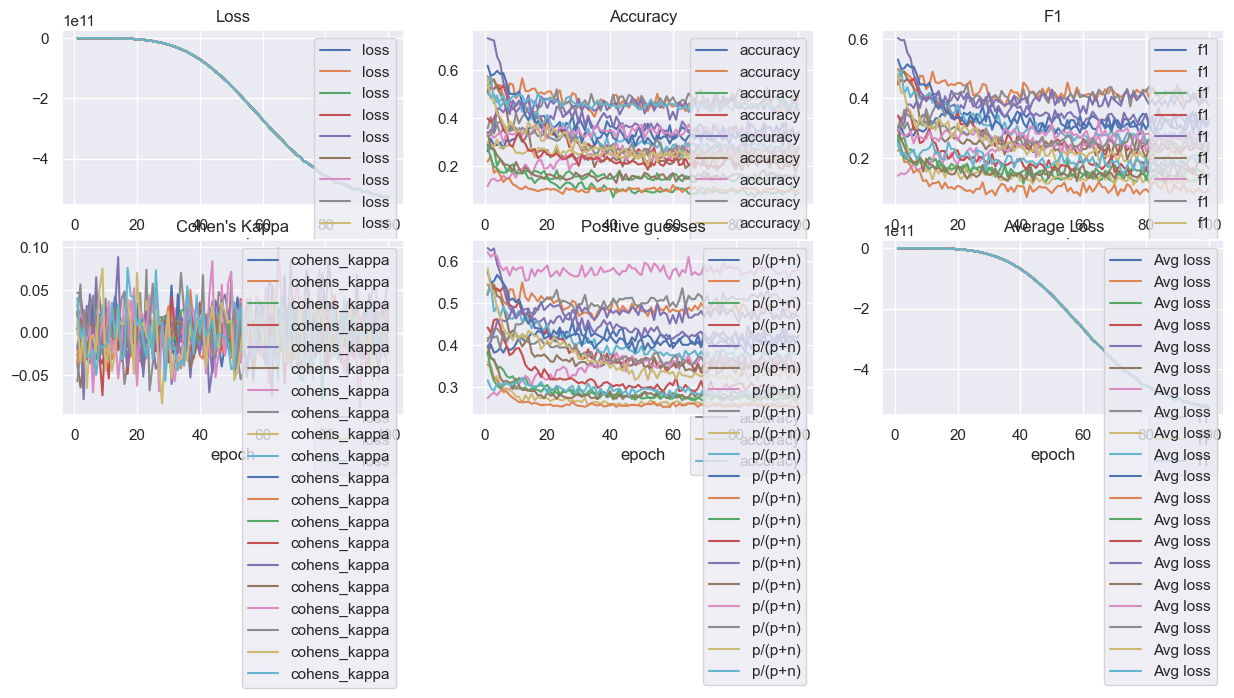

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=3)

def plot(df, axs):
  df = df[["epoch", "loss", "accuracy", "f1", "cohens_kappa", "p/(p+n)", "Avg loss"]].groupby(["epoch"]).mean()
  
  df.plot(y="loss", figsize=(15, 5), title="Loss", ax=axs[0][0])
  df.plot(y="accuracy" , figsize=(15, 5), title="Accuracy", ax=axs[0][1])
  df.plot(y="f1" , figsize=(15, 5), title="F1", ax=axs[0][2])
  df.plot(y="cohens_kappa" , figsize=(15, 5), title="Cohen's Kappa", ax=axs[1][0])
  df.plot(y="p/(p+n)" , figsize=(15, 5), title="Positive guesses", ax=axs[1][1])
  df.plot(y="Avg loss" , figsize=(15, 5), title="Average Loss", ax=axs[1][2])

for joint in joint_names:
  df = df_model_train_jt[df_model_train_hb["joint"] == joint]
  plot(df, axs)

fig.tight_layout(pad=.5)
plt.show()

### Test Evaluation

#### Full Body Evaluation

The evaluation of the whole body as an error boolean.

In [ ]:
df_model_full_body = df_model[df_model["mode"] == Mode.FULL_BODY]
df_model_full_body_test = df_model_full_body[df_model_full_body["train_test"] == "test"]

In [ ]:
df_model_full_body_test[coi].groupby(["difficulty"]).mean().sort_values(by="difficulty", ascending=False)

,p/(p+n),accuracy,precision,recall,f1,cohens_kappa
difficulty,,,,,,
3,1.0,0.116667,0.116667,1.0,1.0,0.0
2,1.0,0.483333,0.483333,1.0,1.0,0.0
1,1.0,0.916667,0.916667,1.0,1.0,0.0
0,1.0,1.000000,1.000000,1.0,1.0,NaN


In [ ]:
df_model_full_body_test[coi_tf_pn + ["difficulty"]].groupby(["difficulty"]).sum()

,tp,tn,fp,fn,p,n
difficulty,,,,,,
0,90.0,0.0,0.0,0.0,90.0,0.0
1,55.0,0.0,5.0,0.0,60.0,0.0
2,29.0,0.0,31.0,0.0,60.0,0.0
3,7.0,0.0,53.0,0.0,60.0,0.0


#### Half Body Evaluation

The evaluation of the body split into two parts (upper and lower body), each as an error boolean.

In [ ]:
# Split the data

df_model_half_body = df_model[df_model["mode"] == Mode.HALF_BODY]
df_model_half_body["joint_names"] = df_model_half_body["joint_id"].apply(lambda x: body_halves[x])
df_model_half_body_test = df_model_half_body[df_model_half_body["train_test"] == "test"]

In [ ]:
df_model_half_body_test[coi + ["joint_names"]].groupby(["joint_names", "difficulty"]).mean()

p/(p+n)  accuracy  precision    recall   f1  \
joint_names difficulty                                                 
Lower Half  0           0.011111  0.477778   1.000000  0.020833  1.0   
            1           0.016667  0.016667   1.000000  0.016667  1.0   
            2           0.000000  0.983333        NaN  0.000000  NaN   
            3           0.000000  1.000000        NaN       NaN  NaN   
Upper Half  0           0.988889  0.988889   1.000000  0.988889  1.0   
            1           1.000000  0.733333   0.733333  1.000000  1.0   
            2           0.983333  0.483333   0.491525  0.966667  1.0   
            3           0.983333  0.266667   0.254237  1.000000  1.0   

                        cohens_kappa  
joint_names difficulty                
Lower Half  0                    0.0  
            1                    0.0  
            2                    0.0  
            3                    NaN  
Upper Half  0                    0.0  
            1                    0.0  
            2                    0.0  
            3                    0.0

In [ ]:
df_model_half_body_test[coi_tf_pn + ["joint_names", "difficulty"]].groupby(["joint_names", "difficulty"]).sum()

tp    tn    fp    fn     p     n
joint_names difficulty                                    
Lower Half  0            1.0  42.0   0.0  47.0   1.0  89.0
            1            1.0   0.0   0.0  59.0   1.0  59.0
            2            0.0  59.0   0.0   1.0   0.0  60.0
            3            0.0  60.0   0.0   0.0   0.0  60.0
Upper Half  0           89.0   0.0   0.0   1.0  89.0   1.0
            1           44.0   0.0  16.0   0.0  60.0   0.0
            2           29.0   0.0  30.0   1.0  59.0   1.0
            3           15.0   1.0  44.0   0.0  59.0   1.0

#### Limb Evaluation

The evaluation of the body split into limbs (Head, Torso, Left and Right Arm, and Left and Right Leg), each as an error boolean.

In [ ]:
# Split the data

df_model_limbs = df_model[df_model["mode"] == Mode.LIMBS]
df_model_limbs["joint_names"] = df_model_limbs["joint_id"].apply(lambda x: limbs[x])
df_model_limbs_test = df_model_limbs[df_model_limbs["train_test"] == "test"]

In [ ]:
df_model_limbs_test[coi + ["joint_names"]].groupby(["joint_names", "difficulty"]).mean()

p/(p+n)  accuracy  precision    recall   f1  \
joint_names difficulty                                                 
Head        0           0.955556  0.955556   1.000000  0.955556  1.0   
            1           0.950000  0.950000   1.000000  0.950000  1.0   
            2           0.900000  0.883333   0.981481  0.898305  1.0   
            3           0.950000  0.283333   0.245614  1.000000  1.0   
Left arm    0           0.722222  0.722222   1.000000  0.722222  1.0   
            1           0.800000  0.666667   0.770833  0.804348  1.0   
            2           0.716667  0.483333   0.511628  0.687500  1.0   
            3           0.700000  0.516667   0.523810  0.709677  1.0   
Left leg    0           0.966667  0.966667   1.000000  0.966667  1.0   
            1           0.983333  0.983333   1.000000  0.983333  1.0   
            2           0.950000  0.933333   0.982456  0.949153  1.0   
            3           0.916667  0.600000   0.618182  0.918919  1.0   
Right arm   0           0.877778  0.877778   1.000000  0.877778  1.0   
            1           0.783333  0.766667   0.957447  0.789474  1.0   
            2           0.850000  0.766667   0.862745  0.862745  1.0   
            3           0.933333  0.400000   0.392857  0.916667  1.0   
Right leg   0           0.800000  0.800000   1.000000  0.800000  1.0   
            1           0.766667  0.766667   1.000000  0.766667  1.0   
            2           0.750000  0.733333   0.977778  0.745763  1.0   
            3           0.816667  0.266667   0.204082  0.666667  1.0   
Torso       0           1.000000  1.000000   1.000000  1.000000  1.0   
            1           1.000000  1.000000   1.000000  1.000000  1.0   
            2           0.983333  0.966667   0.983051  0.983051  1.0   
            3           1.000000  0.383333   0.383333  1.000000  1.0   

                        cohens_kappa  
joint_names difficulty                
Head        0                    0.0  
            1                    0.0  
            2                    0.0  
            3                    0.0  
Left arm    0                    0.0  
            1                    0.0  
            2                    0.0  
            3                    0.0  
Left leg    0                    0.0  
            1                    0.0  
            2                    0.0  
            3                    0.0  
Right arm   0                    0.0  
            1                    0.0  
            2                    0.0  
            3                    0.0  
Right leg   0                    0.0  
            1                    0.0  
            2                    0.0  
            3                    0.0  
Torso       0                    NaN  
            1                    NaN  
            2                    0.0  
            3                    0.0

In [ ]:
df_model_limbs_test[coi_tf_pn + ["joint_names", "difficulty"]].groupby(["joint_names", "difficulty"]).sum()

tp   tn    fp    fn     p     n
joint_names difficulty                                   
Head        0           86.0  0.0   0.0   4.0  86.0   4.0
            1           57.0  0.0   0.0   3.0  57.0   3.0
            2           53.0  0.0   1.0   6.0  54.0   6.0
            3           14.0  3.0  43.0   0.0  57.0   3.0
Left arm    0           65.0  0.0   0.0  25.0  65.0  25.0
            1           37.0  3.0  11.0   9.0  48.0  12.0
            2           22.0  7.0  21.0  10.0  43.0  17.0
            3           22.0  9.0  20.0   9.0  42.0  18.0
Left leg    0           87.0  0.0   0.0   3.0  87.0   3.0
            1           59.0  0.0   0.0   1.0  59.0   1.0
            2           56.0  0.0   1.0   3.0  57.0   3.0
            3           34.0  2.0  21.0   3.0  55.0   5.0
Right arm   0           79.0  0.0   0.0  11.0  79.0  11.0
            1           45.0  1.0   2.0  12.0  47.0  13.0
            2           44.0  2.0   7.0   7.0  51.0   9.0
            3           22.0  2.0  34.0   2.0  56.0   4.0
Right leg   0           72.0  0.0   0.0  18.0  72.0  18.0
            1           46.0  0.0   0.0  14.0  46.0  14.0
            2           44.0  0.0   1.0  15.0  45.0  15.0
            3           10.0  6.0  39.0   5.0  49.0  11.0
Torso       0           90.0  0.0   0.0   0.0  90.0   0.0
            1           60.0  0.0   0.0   0.0  60.0   0.0
            2           58.0  0.0   1.0   1.0  59.0   1.0
            3           23.0  0.0  37.0   0.0  60.0   0.0

#### Joint Evaluation

The evaluation of the body as an error class.

In [ ]:
# Split the data

df_model_joints = df_model[df_model["mode"] == Mode.JOINTS]
df_model_joints["joint_names"] = df_model_joints["joint_id"].apply(lambda x: joint_names[x])
df_model_joints_test = df_model_joints[df_model_joints["train_test"] == "test"]

In [ ]:
df_model_joints_test[coi + ["joint_names"]].groupby(["joint_names", "difficulty"]).mean()

p/(p+n)  accuracy  precision    recall        f1  \
joint_names difficulty                                                      
Head        0           0.433333  0.366667   0.536585  0.366667  0.750000   
            1           0.400000  0.300000   0.461538  0.300000  0.750000   
            2           0.391667  0.291667   0.441558  0.285714  0.750000   
            3           0.400000  0.291667   0.192308  0.170455  0.700000   
Left ankle  0           0.561111  0.477778   0.452055  0.485294  0.742424   
...                          ...       ...        ...       ...       ...   
Torso       3           0.291667  0.333333   0.215385  0.152174  0.607143   
Waist       0           0.333333  0.166667   0.285714  0.166667  0.750000   
            1           0.333333  0.166667   0.285714  0.166667  0.750000   
            2           0.333333  0.175000   0.285714  0.168067  0.750000   
            3           0.358333  0.433333   0.246575  0.236842  0.583333   

                        cohens_kappa  
joint_names difficulty                
Head        0                    0.0  
            1                    0.0  
            2                    0.0  
            3                    0.0  
Left ankle  0                    0.0  
...                              ...  
Torso       3                    0.0  
Waist       0                    0.0  
            1                    0.0  
            2                    0.0  
            3                    0.0  

[80 rows x 6 columns]

In [ ]:
df_model_joints_test[coi_tf_pn + ["difficulty", "joint_names"]].groupby(["joint_names", "difficulty"]).sum()

tp    tn    fp     fn      p      n
joint_names difficulty                                       
Head        0           66.0  33.0  57.0  114.0  123.0  147.0
            1           36.0  18.0  42.0   84.0   78.0  102.0
            2           34.0  18.0  43.0   85.0   77.0  103.0
            3           15.0  29.0  63.0   73.0   78.0  102.0
Left ankle  0           66.0  54.0  80.0   70.0  146.0  124.0
...                      ...   ...   ...    ...    ...    ...
Torso       3           14.0  37.0  51.0   78.0   65.0  115.0
Waist       0           30.0  15.0  75.0  150.0  105.0  165.0
            1           20.0  10.0  50.0  100.0   70.0  110.0
            2           20.0  11.0  50.0   99.0   70.0  110.0
            3           18.0  49.0  55.0   58.0   73.0  107.0

[80 rows x 6 columns]

<Axes: title={'center': 'Joints'}, xlabel='joint_names,difficulty'>

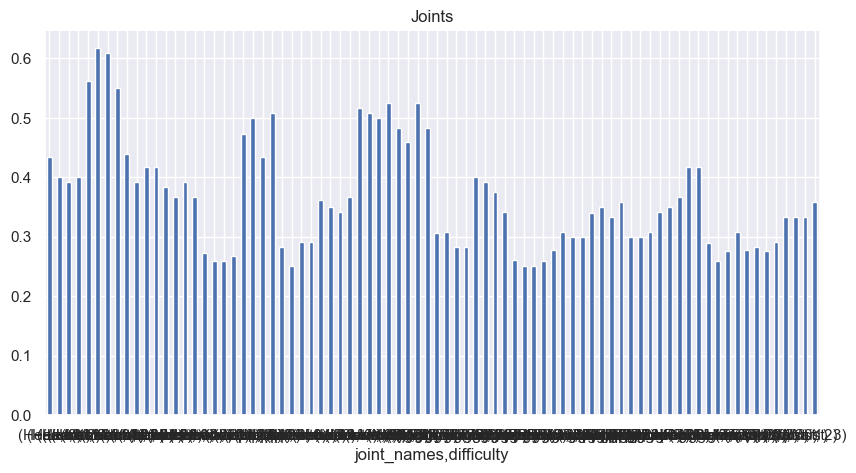

In [ ]:
df_model_joints_test[coi + ["joint_names"]].groupby(["joint_names", "difficulty"]).mean()